# Problem 4 --- Simulating Synchronous SGD via Gradient Accumulation Under Limited GPU Budget (15 points)

**Version: GPU (A100 / L4 on Google Colab)**

In large-scale distributed training, synchronous SGD with data parallelism increases the **global batch size** by aggregating gradients across many workers at every iteration. While access to GPU clusters may be limited, the machine learning behavior of synchronous SGD (large global batch updates) can be approximated on a single GPU using **gradient accumulation**.

In this problem, you will use a single GPU (A100 or L4) to simulate synchronous SGD across multiple workers by accumulating gradients over multiple mini-batches before performing a parameter update.

---

## Experimental Setup (Must Follow Exactly)

| Parameter | Value |
|---|---|
| Dataset | CIFAR-10 |
| Training subset | First 10,240 training images |
| Test subset | First 2,048 test images |
| Model | ResNet-18 (standard PyTorch) |
| Optimizer | SGD with momentum = 0.9 |
| Learning rate | 0.1 (constant; no warmup, no decay) |
| Weight decay | 5e-4 |
| Per-mini-batch size | 64 |
| Data augmentation | Random crop + horizontal flip |
| Mixed precision | Disabled |
| Gradient clipping | Disabled |

All experiments must be run on a **single GPU**. Do not use data parallelism or distributed training.

### Gradient Accumulation Factors

In real synchronous SGD with $N$ workers, the global batch size is $64 \times N$. On a single GPU, you approximate this by accumulating gradients for $K$ steps:

$$B_{\text{effective}} = 64 \times K$$

We use: $K \in \{1, 2, 4, 8\}$

### Fixed Epoch Budget

Each configuration trains for **$E = 5$ epochs** over the 10,240-image training subset. Since one epoch consists of $\lfloor 10240 / (64 \times K) \rfloor$ optimizer updates, the total number of updates $U$ varies by $K$:

$$U = E \times \left\lfloor \frac{10240}{64 \times K} \right\rfloor$$

| $K$ | Eff. Batch | Updates/Epoch | Total $U$ (5 epochs) | Total Images |
|---|---|---|---|---|
| 1 | 64  | 160 | 800 | 51,200 |
| 2 | 128 | 80  | 400 | 51,200 |
| 4 | 256 | 40  | 200 | 51,200 |
| 8 | 512 | 20  | 100 | 51,200 |

> Every configuration sees the **same total number of training images** (51,200). Larger $K$ naturally results in fewer optimizer updates per epoch.

---
## Step 0: Environment Setup & GPU Check

First, let's verify we have GPU access and import all necessary libraries.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    raise RuntimeError("GPU not available! Go to Runtime > Change runtime type > select GPU (A100 or L4).")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.4 GB


---
## Step 1: Set Random Seeds for Reproducibility

We fix random seeds so that results are reproducible across runs.

In [2]:
def set_seed(seed=42):
    """Set all random seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seeds set.")

Random seeds set.


---
## Step 2: Prepare CIFAR-10 Data (Fixed Subsets)

We use the **first 10,240 training images** and **first 2,048 test images** as fixed subsets.

Data augmentation: random crop (with padding=4) and random horizontal flip for training; only normalization for testing.

In [3]:
# CIFAR-10 normalization statistics
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)

# Training transforms: random crop + horizontal flip
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Test transforms: only normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Download CIFAR-10
full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
full_test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

# Fixed subsets
train_subset = Subset(full_train_dataset, range(10240))
test_subset = Subset(full_test_dataset, range(2048))

print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Training subset size: 10240
Test subset size: 2048


---
## Step 3: Helper Functions

We define helper functions to create the model, data loaders, and run the training loop with gradient accumulation.

In [4]:
def create_model():
    """Create a fresh ResNet-18 model for CIFAR-10."""
    model = models.resnet18(num_classes=10)
    model = model.to(device)
    return model


def create_optimizer(model):
    """Create SGD optimizer with the specified hyperparameters."""
    return optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)


def create_train_loader():
    """Create training data loader with batch size 64.

    We set drop_last=False. The training subset (10,240) is divisible by 64,
    so all batches will be full-sized.
    """
    return DataLoader(train_subset, batch_size=64, shuffle=True,
                      num_workers=2, pin_memory=True, drop_last=False)


def create_test_loader():
    """Create test data loader."""
    return DataLoader(test_subset, batch_size=256, shuffle=False,
                      num_workers=2, pin_memory=True)


def evaluate(model, test_loader):
    """Evaluate model accuracy on the test subset."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100.0 * correct / total

### Understanding Gradient Accumulation

In standard training, we do:
1. Forward pass on a mini-batch
2. Backward pass to compute gradients
3. Optimizer step to update parameters
4. Zero gradients

With gradient accumulation ($K$ steps), we:
1. **Repeat $K$ times**: forward + backward (gradients accumulate in `.grad`)
2. **Divide accumulated gradients by $K$** (to get the average)
3. Optimizer step
4. Zero gradients

This simulates a batch of size $64 \times K$ using $K$ mini-batches of size 64.

---
## Part 1: Micro-Iteration Time (Forward+Backward) vs $K$ [4 points]

**Task:** For each value of $K$, measure the average time (in ms) for a single *micro-iteration* (one forward and backward pass on a mini-batch of size 64).

- Warm up for 20 micro-iterations (not timed)
- Time the next 80 micro-iterations and report the mean
- Plot micro-iteration time vs. $K$

**Why do we warm up?** The first few iterations on GPU involve JIT compilation, memory allocation, and CUDA kernel caching. Warming up ensures stable timing measurements.

In [7]:
K_values = [1, 2, 4, 8]
micro_iter_times = {}  # K -> mean time in ms

for K in K_values:
    print(f"\n--- Measuring micro-iteration time for K={K} ---")
    set_seed(42)
    model = create_model()
    optimizer = create_optimizer(model)
    criterion = nn.CrossEntropyLoss()
    train_loader = create_train_loader()

    model.train()

    data_iter_ref = [iter(train_loader)]

    def get_batch():
        """Get the next mini-batch, cycling through the dataset."""
        try:
            return next(data_iter_ref[0])
        except StopIteration:
            data_iter_ref[0] = iter(train_loader)
            return next(data_iter_ref[0])

    # TODO: Warmup for 20 micro-iterations (not timed)
    # Remember to move data to device with .to(device)
    for i in range(20):
        images, labels = get_batch()
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Step every K micro-iterations to prevent unbounded grad growth
        if (i + 1) % K == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

    # TODO: Time 80 micro-iterations
    # - For each micro-iteration: forward pass, compute loss, backward pass
    # - Use torch.cuda.synchronize() before start/end timing for accurate GPU measurement
    # - Measure time (in ms) for each micro-iteration
    # - Do optimizer step every K micro-iterations to avoid unbounded gradient accumulation
    # - Store mean time in micro_iter_times[K]

    times_ms = []
    optimizer.zero_grad(set_to_none=True)

    for i in range(80):
        images, labels = get_batch()
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        # Accurate GPU timing: sync before/after the region
        torch.cuda.synchronize()
        t0 = time.perf_counter()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.cuda.synchronize()
        t1 = time.perf_counter()

        times_ms.append((t1 - t0) * 1000.0)

        # Do the optimizer step OUTSIDE the timed region
        if (i + 1) % K == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

    micro_iter_times[K] = float(np.mean(times_ms))
    print(f"K={K}: mean micro-iteration time = {micro_iter_times[K]:.3f} ms")

    del model, optimizer
    torch.cuda.empty_cache()


--- Measuring micro-iteration time for K=1 ---
K=1: mean micro-iteration time = 8.442 ms

--- Measuring micro-iteration time for K=2 ---
K=2: mean micro-iteration time = 10.359 ms

--- Measuring micro-iteration time for K=4 ---
K=4: mean micro-iteration time = 9.301 ms

--- Measuring micro-iteration time for K=8 ---
K=8: mean micro-iteration time = 8.988 ms


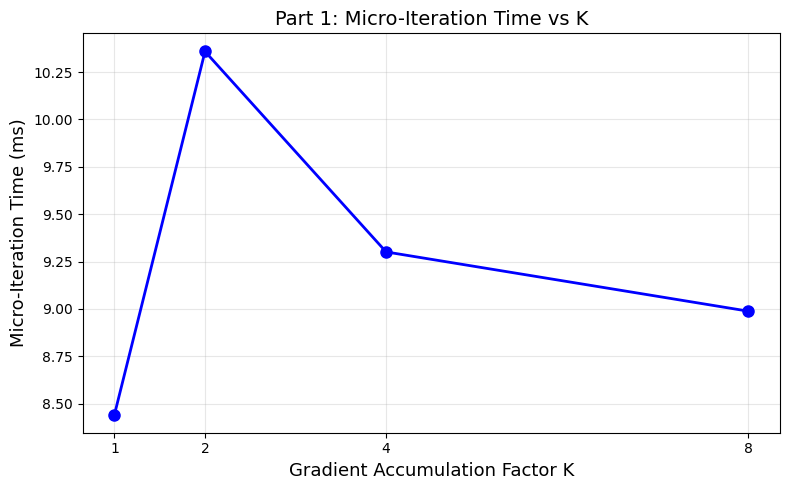

In [8]:

# Plot: Micro-iteration time vs K
plt.figure(figsize=(8, 5))
plt.plot(K_values, [micro_iter_times[k] for k in K_values], 'bo-', markersize=8, linewidth=2)
plt.xlabel('Gradient Accumulation Factor K', fontsize=13)
plt.ylabel('Micro-Iteration Time (ms)', fontsize=13)
plt.title('Part 1: Micro-Iteration Time vs K', fontsize=14)
plt.xticks(K_values)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Part 1: Your Answer

**Explain why the micro-iteration time does or does not change with $K$ in a single-GPU setup.**

Although the graph is not perfectly flat, there is no consistent trend with increasing K. Each micro-iteration processes the same batch size (64) and performs identical forward and backward computations, so the theoretical compute cost is independent of K. The small fluctuations observed are due to GPU scheduling, memory allocation patterns, and synchronization noise rather than changes in SGD behavior. Therefore, gradient accumulation does not materially affect micro-iteration time on a single GPU.

---
## Part 2: Update Time and Effective Throughput [4 points]

**Task:** For each value of $K$, measure:
- Average *optimizer update time* (seconds per optimizer step), averaged over the middle 60% of updates (skip first 20% and last 20%).

The total number of updates $U$ is computed per $K$ as $U = 5 \times \lfloor 10240 / (64 \times K) \rfloor$.

Then compute the *effective throughput* (images/sec):
$$\text{Throughput} = \frac{64 \times K}{T_{\text{update}}}$$

- Plot throughput vs. effective batch size ($64 \times K$)

In [9]:
NUM_EPOCHS = 5
TRAIN_SIZE = len(train_subset)  # 10240

update_times = {}     # K -> mean update time in seconds
throughputs = {}       # K -> images/sec

for K in K_values:
    U = NUM_EPOCHS * (TRAIN_SIZE // (64 * K))
    skip = U // 5  # skip first/last 20%
    print(f"\n--- Measuring update time for K={K} (U={U}, middle window: [{skip}:{U - skip}]) ---")
    set_seed(42)
    model = create_model()
    optimizer = create_optimizer(model)
    criterion = nn.CrossEntropyLoss()
    train_loader = create_train_loader()
    data_iter_ref = [iter(train_loader)]

    def get_batch():
        try:
            return next(data_iter_ref[0])
        except StopIteration:
            data_iter_ref[0] = iter(train_loader)
            return next(data_iter_ref[0])

    model.train()

    # TODO: For each of U optimizer updates:
    # - Use torch.cuda.synchronize() before start/end timing
    # - Time the full update (K micro-iterations + optimizer step)
    # - Each micro-iteration: get batch, move to device, forward, loss, (loss/K).backward()
    # - After K micro-iterations: optimizer.step()
    # - Record update time
    # Then: average over middle 60% of updates (skip first/last 20%)
    # Store mean_update_time in update_times[K]
    # Compute throughput = (64 * K) / mean_update_time and store in throughputs[K]

    times = []

    # Ensure clean grads
    optimizer.zero_grad(set_to_none=True)

    for u in range(U):
        # Time the FULL update: K micro-iterations + optimizer.step()
        torch.cuda.synchronize()
        t0 = time.perf_counter()

        optimizer.zero_grad(set_to_none=True)

        for k in range(K):
            images, labels = get_batch()
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Average gradient over the effective batch
            (loss / K).backward()

        optimizer.step()

        torch.cuda.synchronize()
        t1 = time.perf_counter()

        times.append(t1 - t0)

    # Average over middle 60% of updates
    mid_times = times[skip:U - skip]
    mean_update_time = float(np.mean(mid_times))

    update_times[K] = mean_update_time
    throughputs[K] = (64 * K) / mean_update_time

    print(f"K={K}: mean update time (middle 60%) = {mean_update_time:.6f} s")
    print(f"K={K}: throughput = {throughputs[K]:.2f} images/sec")

    del model, optimizer
    torch.cuda.empty_cache()


--- Measuring update time for K=1 (U=800, middle window: [160:640]) ---
K=1: mean update time (middle 60%) = 0.013689 s
K=1: throughput = 4675.38 images/sec

--- Measuring update time for K=2 (U=400, middle window: [80:320]) ---
K=2: mean update time (middle 60%) = 0.026765 s
K=2: throughput = 4782.43 images/sec

--- Measuring update time for K=4 (U=200, middle window: [40:160]) ---
K=4: mean update time (middle 60%) = 0.054047 s
K=4: throughput = 4736.58 images/sec

--- Measuring update time for K=8 (U=100, middle window: [20:80]) ---
K=8: mean update time (middle 60%) = 0.108115 s
K=8: throughput = 4735.69 images/sec


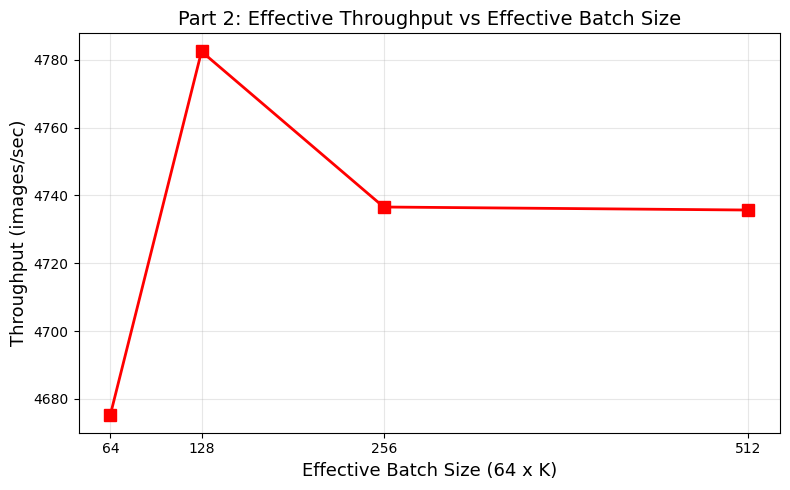

In [10]:
# Plot: Throughput vs Effective Batch Size
effective_batch_sizes = [64 * K for K in K_values]

plt.figure(figsize=(8, 5))
plt.plot(effective_batch_sizes, [throughputs[k] for k in K_values], 'rs-', markersize=8, linewidth=2)
plt.xlabel('Effective Batch Size (64 x K)', fontsize=13)
plt.ylabel('Throughput (images/sec)', fontsize=13)
plt.title('Part 2: Effective Throughput vs Effective Batch Size', fontsize=14)
plt.xticks(effective_batch_sizes)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Part 2: Your Answer

**Does throughput improve proportionally with $K$? Why or why not?**

Throughput does **not** improve proportionally with K.

While increasing K increases the effective batch size, each optimizer update requires K forward and backward passes. Thus, update time grows approximately linearly with K:

$$
T_{\text{update}}(K) \approx K \cdot T_{\text{micro}} + T_{\text{step}}
$$

Although the optimizer step overhead is amortized as K increases (leading to a small improvement from K=1 to K=2), the dominant cost remains the K micro-iterations. As a result, throughput quickly saturates instead of scaling linearly with K.

This explains why the plot shows only a slight improvement rather than proportional scaling.

---
## Part 3: Convergence Under a Fixed Epoch Budget [4 points]

**Task:** For each value of $K$, train for $E=5$ epochs (so $U$ varies by $K$) and record:
- Training loss at each epoch boundary
- Test accuracy at the end of training

Plot training loss vs. epoch for all $K$ on the same figure.

> All configurations see the same total data (51,200 images). Smaller $K$ gets more optimizer updates.

In [14]:
NUM_EPOCHS = 5
TRAIN_SIZE = len(train_subset)  # 10240

# Store results
all_losses = {}        # K -> list of (epoch, loss)
final_test_accs = {}   # K -> test accuracy

test_loader = create_test_loader()

for K in K_values:
    updates_per_epoch = TRAIN_SIZE // (64 * K)
    U = NUM_EPOCHS * updates_per_epoch
    print(f"\n{'='*60}")
    print(f"Training with K={K} (effective batch size = {64*K})")
    print(f"  Updates/epoch = {updates_per_epoch}, Total U = {U}")
    print(f"{'='*60}")

    set_seed(42)
    model = create_model()
    optimizer = create_optimizer(model)
    criterion = nn.CrossEntropyLoss()
    train_loader = create_train_loader()
    data_iter_ref = [iter(train_loader)]

    def get_batch():
        try:
            return next(data_iter_ref[0])
        except StopIteration:
            data_iter_ref[0] = iter(train_loader)
            return next(data_iter_ref[0])

    model.train()

    # TODO: Train for NUM_EPOCHS epochs, each with updates_per_epoch optimizer updates.
    # For each epoch:
    #   - Track running loss across all updates in the epoch
    #   - Each update: zero_grad, K micro-iterations with (loss/K).backward(), optimizer.step()
    #   - Remember to move data to device with .to(device)
    #   - At end of epoch: compute average loss, append (epoch, avg_loss) to losses_log
    #   - Print epoch loss
    # After training: evaluate on test_loader, store in final_test_accs[K]
    # Store losses_log in all_losses[K]

    losses_log = []

    for epoch in range(1, NUM_EPOCHS + 1):
        epoch_loss_sum = 0.0
        epoch_micro_batches = 0  # counts 64-sized micro-batches (should be updates_per_epoch * K)

        for upd in range(updates_per_epoch):
            optimizer.zero_grad(set_to_none=True)

            # K micro-iterations per optimizer update
            for k in range(K):
                images, labels = get_batch()
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(images)
                loss = criterion(outputs, labels)

                # accumulate averaged gradients
                (loss / K).backward()

                # log loss on the real (unscaled) micro-batch
                epoch_loss_sum += loss.item()
                epoch_micro_batches += 1

            optimizer.step()

        avg_epoch_loss = epoch_loss_sum / max(1, epoch_micro_batches)
        losses_log.append((epoch, avg_epoch_loss))
        print(f"Epoch {epoch}/{NUM_EPOCHS} | avg train loss = {avg_epoch_loss:.4f}")

    # Final evaluation
    test_acc = evaluate(model, test_loader)
    final_test_accs[K] = test_acc
    all_losses[K] = losses_log

    print(f"Final Test Acc (K={K}): {test_acc:.2f}%")

    del model, optimizer
    torch.cuda.empty_cache()


Training with K=1 (effective batch size = 64)
  Updates/epoch = 160, Total U = 800
Epoch 1/5 | avg train loss = 2.8729
Epoch 2/5 | avg train loss = 1.9601
Epoch 3/5 | avg train loss = 1.7896
Epoch 4/5 | avg train loss = 1.6857
Epoch 5/5 | avg train loss = 1.6129
Final Test Acc (K=1): 40.23%

Training with K=2 (effective batch size = 128)
  Updates/epoch = 80, Total U = 400
Epoch 1/5 | avg train loss = 3.3129
Epoch 2/5 | avg train loss = 2.0507
Epoch 3/5 | avg train loss = 1.8882
Epoch 4/5 | avg train loss = 1.7232
Epoch 5/5 | avg train loss = 1.6468
Final Test Acc (K=2): 40.23%

Training with K=4 (effective batch size = 256)
  Updates/epoch = 40, Total U = 200
Epoch 1/5 | avg train loss = 3.4241
Epoch 2/5 | avg train loss = 2.1558
Epoch 3/5 | avg train loss = 2.0206
Epoch 4/5 | avg train loss = 1.8533
Epoch 5/5 | avg train loss = 1.7462
Final Test Acc (K=4): 38.82%

Training with K=8 (effective batch size = 512)
  Updates/epoch = 20, Total U = 100
Epoch 1/5 | avg train loss = 3.6878
E

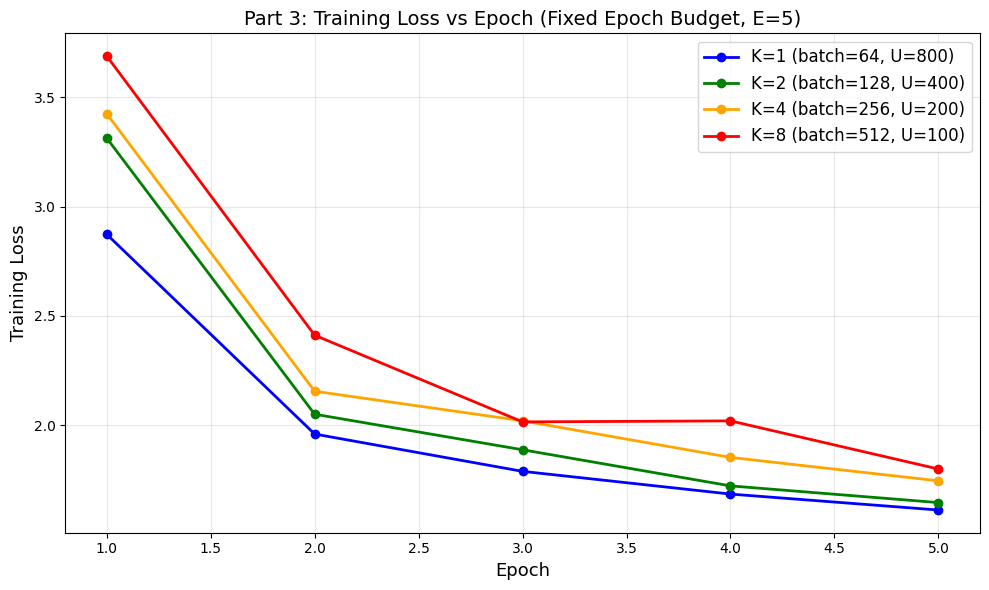


Final Test Accuracies:
  K=1 (batch=64, U=800): 40.23%
  K=2 (batch=128, U=400): 40.23%
  K=4 (batch=256, U=200): 38.82%
  K=8 (batch=512, U=100): 36.18%


In [15]:
# Plot: Training loss vs epoch for all K
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'orange', 'red']

for K, color in zip(K_values, colors):
    epochs = [x[0] for x in all_losses[K]]
    losses = [x[1] for x in all_losses[K]]
    plt.plot(epochs, losses, f'-o', color=color, markersize=6, linewidth=2,
             label=f'K={K} (batch={64*K}, U={NUM_EPOCHS * (TRAIN_SIZE // (64 * K))})')

plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Training Loss', fontsize=13)
plt.title('Part 3: Training Loss vs Epoch (Fixed Epoch Budget, E=5)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final test accuracies
print("\nFinal Test Accuracies:")
for K in K_values:
    U = NUM_EPOCHS * (TRAIN_SIZE // (64 * K))
    print(f"  K={K} (batch={64*K}, U={U}): {final_test_accs[K]:.2f}%")

### Part 3: Your Answer

**Discuss how increasing effective batch size affects convergence when all configurations train for the same number of epochs (same total data).**

Increasing the effective batch size (larger $K$) slows convergence under a fixed epoch budget, even though all configurations see the same total number of training images.

From the plot, smaller $K$ (e.g., $K=1$) consistently achieves lower training loss at every epoch, while larger $K$ (e.g., $K=8$) converges more slowly and ends with higher loss after 5 epochs.

The reason is that although all configurations process the same total number of images (51,200), smaller $K$ performs more optimizer updates:

- Smaller batch $\rightarrow$ more updates $\rightarrow$ more frequent parameter adjustments  
- Larger batch $\rightarrow$ fewer updates $\rightarrow$ slower parameter refinement  

While larger batches provide lower-variance gradient estimates, they perform fewer update steps within the same number of epochs. As a result, convergence (in terms of training loss) is slower for larger effective batch sizes.

---
## Required Summary Table

Run the cell below to generate the summary table with all measured values.

In [16]:
print("="*90)
print("SUMMARY TABLE")
print("="*90)
print(f"{'K':>3} | {'Eff. Batch':>10} | {'Total U':>8} | {'Micro-Iter (ms)':>15} | {'Update Time (s)':>15} | {'Test Acc (%)':>12}")
print("-"*90)
for K in K_values:
    U = NUM_EPOCHS * (TRAIN_SIZE // (64 * K))
    print(f"{K:>3} | {64*K:>10} | {U:>8} | {micro_iter_times[K]:>15.2f} | {update_times[K]:>15.4f} | {final_test_accs[K]:>12.2f}")
print("="*90)

SUMMARY TABLE
  K | Eff. Batch |  Total U | Micro-Iter (ms) | Update Time (s) | Test Acc (%)
------------------------------------------------------------------------------------------
  1 |         64 |      800 |            8.44 |          0.0137 |        40.23
  2 |        128 |      400 |           10.36 |          0.0268 |        40.23
  4 |        256 |      200 |            9.30 |          0.0540 |        38.82
  8 |        512 |      100 |            8.99 |          0.1081 |        36.18


---
## Part 4: Connection to Real Synchronous SGD [3 points]

Answer the following questions in the cells below.

### Q4a: Which aspects of synchronous SGD are captured by gradient accumulation?

Gradient accumulation captures the **algorithmic behavior** of synchronous SGD:

- It increases the effective global batch size to $64 \times K$.
- Gradients are averaged across K micro-batches before an update.
- Parameter updates occur using the same averaged gradient that would be produced by $K$ workers in synchronous data parallel training.
- The optimization trajectory (for fixed batch size and learning rate) matches large-batch synchronous SGD in expectation.

Thus, gradient accumulation correctly simulates the mathematical update rule of synchronous SGD.

### Q4b: Which system-level effects are missing?

Gradient accumulation does not capture system-level distributed effects such as:

- Inter-GPU communication (all-reduce) latency
- Communication bandwidth limits
- Synchronization barriers between workers
- Straggler effects (slowest worker determines step time)
- Network topology constraints (PCIe vs NVLink vs InfiniBand)

Since everything runs on a single GPU, there is no gradient communication overhead or synchronization delay.

### Q4c: In real multi-GPU synchronous SGD, how would the missing effects change iteration time, scaling efficiency, and the optimal number of workers?

In real multi-GPU synchronous SGD:

$$
T_{\text{iteration}} = T_{\text{compute}} + T_{\text{all-reduce}}
$$

As the number of workers increases, communication time grows and can eventually dominate computation time.

- Iteration time increases due to communication overhead.
- Scaling efficiency becomes sub-linear.
- Adding more workers yields diminishing returns.
- There exists an optimal number of workers that balances compute parallelism and communication cost.

Thus, real distributed training does not scale perfectly, unlike single-GPU gradient accumulation which ignores communication costs.

---
## Notes

- The goal is to observe trends; minor differences across A100 vs. L4 are expected.
- All configurations train for E=5 epochs (51,200 images). The number of optimizer updates varies by K.
- Do not modify the dataset subsets, model, or hyperparameters.
- Keep your code deterministic where possible (random seeds are set above).